# **Correlator of Lorentz force felt by heavy quarks immersed in the Glasma**

Default simulation parameters chosen for Pb-Pb at 5.02 TeV.


In [1]:
import numpy as np

# General parameters
su_group = 'su2'        # Gauge group
system = 'PbPb'         # Pb-Pb or pPb
folder = 'corr_pb+pb_5020gev_su2_pT_0.5_charm'      # Results folder

# Simulation box parameters
L = 10      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_s = 2.0     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters for Pb-Pb at 5.02 TeV
A = 207     # Mass number
sqrts = 5020        # Center-of-mass energy [GeV]
ns = 50     # Number of color sheets
factor = 0.8        # Ratio between Qs/g^2\mu for Ns = 50 color sheets
Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)         # Saturation momentum [GeV]	
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))           # Running coupling constant		
mu = Qs / (g**2 * factor)           # MV model parameter	
m = 0.1 * g**2 * mu         # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

# Heavy quark related parameters, chosen here for a charm quark
quark = 'charm'     # Quark type
mass = 1.5      # Heavy quark mass [GeV]
tau_form = 0.06     # Formation time [fm/c]
nq = 15     # Number of heavy quark antiquark pairs
pT = 0.5    # Initial transverse momentum [GeV]
ntp = 10   # Number of test particles
FONLL = False   # FONLL initial momentum distribution

# Other numerical parameters
nevents = 10    # Number of Glasma events
solveq = 'wilson_lines'     # Solve the equation for the color charge with Wilson lines or gauge potentials
frame = 'milne'         # Milne coordinates or laboratory frame
NUM_CHECKS = False       # Perform numerical checks (compute Casimirs, for example)
FORCE_CORR = True      # Compute the Lorentz force correlator along the trajectory of the heavy quarks

Dictionary with standard MV model paramaters.

In [2]:
p = {
    # General parameters
    'GROUP':    su_group,       # SU(2) or SU(3) group
    'FOLDER':   folder,         # results folder
    'SYSTEM':   system,         # collision system

    # Parameters for simulation box
    'L':    L,           # transverse size [fm]
    'N':    N,            # lattice size
    'DTS':  DTS,             # time steps per transverse spacing
    'TMAX': tau_s,          # max. proper time (tau) [fm/c]

    # Parameters for MV model
    'G':    g,            # YM coupling constant
    'MU':   mu,             # MV model parameter [GeV]
    'M':    m,              # IR regulator [GeV]
    'UV':   uv,           # UV regulator [GeV]
    'NS':   ns,             # number of color sheets
    
    # Parameters for heavy quarks
    'MASS': mass,           # mass of HQ [GeV]
    'TFORM': tau_form,       # formation time of the HQ [fm/c]
    'PT': pT,           # transverse momentum of HQs [GeV]
    'NQ': nq,         # number of heavy quarks
    'NTP': ntp,         # number of test particles
    'FONLL': FONLL,     # FONLL pQCD initialization

    # Numerical parameters
    'NEVENTS': nevents,     # number of Glasma events
    'SOLVEQ': solveq,       # method used to solve the equation for color charge
    'FRAME': frame,         # laboratory of Milne frame
    'NUM_CHECKS': NUM_CHECKS,    # perform numerical checks
    'FORCE_CORR': FORCE_CORR,   # compute correlator of Lorentz force
}

# Option to solve in laboratory frame with Boris push only for solution of color charge equation with Wilson lines, with no numerical checks or force correlator computation
if p['FRAME']=='lab':
    p['SOLVEQ']='wilson lines'
    p['FORCE_CORR']=False
    p['FONLL']=False

Set environment variables.

In [3]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
if p['GROUP'] == 'su2':
    os.environ["GAUGE_GROUP"] = 'su2_complex'
elif p['GROUP'] == 'su3':
    os.environ["GAUGE_GROUP"] = p['GROUP']


# Import relevant modules
import sys
sys.path.append('..')
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda
if p['FRAME']=='milne':
    from curraun.wong_hq_batch import initial_coords, initial_momenta, initial_charge, solve_wong, initial_momenta_fonll
elif p['FRAME']=='lab':
    from curraun.wong_hq_lab import initial_coords, initial_momenta, initial_charge, solve_wong

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

Using CUDA
Using SU(2) complex
Using double precision
Using double precision


Simulation function.

In [4]:
def simulate(p, ev, inner_loop): 
   
    xmu, pmu = {}, {}
    xmu0, pmu0, q0, xmu1, pmu1, q1 = {}, {}, {}, {}, {}, {}
    fields, charge = {}, {}
    # If NUM_CHECKS = True
    constraint, casimirs = {}, {}
    # If FORCE_CORR = True
    correlators = {}
    correlators['EformE'], correlators['FformF'] = {}, {}
    tags_corr = ['naive', 'transported']
    for tag in tags_corr:
        correlators['EformE'][tag], correlators['FformF'][tag] = {}, {}
    fieldsform = {}
    fieldsform['E'], fieldsform['F'] = {}, {}
    electric_fields, lorentz_force, force_correlators = {}, {}, {}

    # Derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc
    p['E0'] = E0
    DT = 1.0 / p['DTS']
    formt = int(p['TFORM'] / a * p['DTS'])

    s = core.Simulation(p['N'], DT, p['G'])
    va = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
    vb = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
    initial.init(s, va, vb)

    if use_cuda:
        s.copy_to_device()

    for t in range(len(inner_loop)):
        core.evolve_leapfrog(s)

        if t>=formt:  
            if p['FONLL']:
                initial_momenta_fonll(p)
                pt, N = p['PTFONLL'], p['NFONLL']
                for ipt in range(len(pt)):
                    p['PT'] = pt[ipt]
                    for ip in range(N[ipt]):
                        tagq = 'ev_' + str(ev+1) + '_q_' + str(ipt+1) + '_n_' + str(ip+1)
                        tagaq = 'ev_' + str(ev+1) + '_aq_' + str(ipt+1) + '_n_' + str(ip+1)
                        tags = [tagq, tagaq]

                        if t==formt:
                            # Initialize quark
                            xmu0[tagq] = initial_coords(p)
                            pmu0[tagq] = initial_momenta(p)
                            q0[tagq] = initial_charge(p)

                            # Initialize antiquark
                            xmu0[tagaq] = xmu0[tagq]
                            pmu0[tagaq] = [pmu0[tagq][0], -pmu0[tagq][1], -pmu0[tagq][2], pmu0[tagq][3]]
                            q0[tagaq] = initial_charge(p)

                            for tag in tags:
                                solve_wong(s, p, t, xmu0[tag], pmu0[tag], q0[tag], xmu, pmu, fields, charge, tag, constraint, casimirs, correlators, fieldsform, electric_fields, lorentz_force, force_correlators)

                        elif t>formt:
                            for tag in tags:
                                xmu1[tag], pmu1[tag], q1[tag] = solve_wong(s, p, t, xmu0[tag], pmu0[tag], q0[tag], xmu, pmu, fields, charge, tag, constraint, casimirs, correlators, fieldsform, electric_fields, lorentz_force, force_correlators)
                                # Swap x, p, q for next time step
                                xmu0[tag], pmu0[tag], q0[tag] = xmu1[tag], pmu1[tag], q1[tag]

            else:
                for q in range(p['NQ']):
                    for tp in range(p['NTP']):

                        tagq = 'ev_' + str(ev+1) + '_q_' + str(q+1) + '_tp_' + str(tp+1)
                        tagaq = 'ev_' + str(ev+1) + '_aq_' + str(q+1) + '_tp_' + str(tp+1)
                        tags = [tagq, tagaq]

                        if t==formt:
                            # Initialize quark
                            xmu0[tagq] = initial_coords(p)
                            pmu0[tagq] = initial_momenta(p)
                            q0[tagq] = initial_charge(p)

                            # Initialize antiquark
                            xmu0[tagaq] = xmu0[tagq]
                            pmu0[tagaq] = [pmu0[tagq][0], -pmu0[tagq][1], -pmu0[tagq][2], pmu0[tagq][3]]
                            q0[tagaq] = initial_charge(p)

                            for tag in tags:
                                solve_wong(s, p, t, xmu0[tag], pmu0[tag], q0[tag], xmu, pmu, fields, charge, tag, constraint, casimirs, correlators, fieldsform, electric_fields, lorentz_force, force_correlators)

                        elif t>formt:
                            for tag in tags:
                                xmu1[tag], pmu1[tag], q1[tag] = solve_wong(s, p, t, xmu0[tag], pmu0[tag], q0[tag], xmu, pmu, fields, charge, tag, constraint, casimirs, correlators, fieldsform, electric_fields, lorentz_force, force_correlators)
                                # Swap x, p, q for next time step
                                xmu0[tag], pmu0[tag], q0[tag] = xmu1[tag], pmu1[tag], q1[tag]

        inner_loop.update()

    if use_cuda:
        s.copy_to_host()
        cuda.current_context().deallocations.clear()

    if p['FONLL']:
        for ipt in range(len(pt)):
            for ip in range(N[ipt]):
                tagq = 'ev_' + str(ev+1) + '_q_' + str(ipt+1) + '_n_' + str(ip+1)
                tagaq = 'ev_' + str(ev+1) + '_aq_' + str(ipt+1) + '_n_' + str(ip+1)
                tags = [tagq, tagaq]

                for tag in tags:
                    output = {}
                    output['xmu'], output['pmu'] = xmu[tag], pmu[tag]
                    if p['NUM_CHECKS']:
                        output['constraint'], output['casimirs'] = constraint[tag], casimirs[tag]
                    if p['FORCE_CORR']:
                        output['correlators'] = {}
                        types_corr = ['EformE', 'FformF']
                        tags_corr = ['naive', 'transported']
                        for type_corr in types_corr:
                            output['correlators'][type_corr] = {}
                            for tag_corr in tags_corr:
                                output['correlators'][type_corr][tag_corr] = correlators[type_corr][tag_corr][tag]    

                    filename = tag + '.pickle'
                    with open(filename, 'wb') as handle:
                        pickle.dump(output, handle)

    else:
        for q in range(p['NQ']):
            for tp  in range(p['NTP']):
                tagq = 'ev_' + str(ev+1) + '_q_' + str(q+1) + '_tp_' + str(tp+1)
                tagaq = 'ev_' + str(ev+1) + '_aq_' + str(q+1) + '_tp_' + str(tp+1)
                tags = [tagq, tagaq]

                for tag in tags:
                    output = {}
                    output['xmu'], output['pmu'] = xmu[tag], pmu[tag]
                    if p['NUM_CHECKS']:
                        output['constraint'], output['casimirs'] = constraint[tag], casimirs[tag]
                    if p['FORCE_CORR']:
                        output['correlators'] = {}
                        types_corr = ['EformE', 'FformF']
                        tags_corr = ['naive', 'transported']
                        for type_corr in types_corr:
                            output['correlators'][type_corr] = {}
                            for tag_corr in tags_corr:
                                output['correlators'][type_corr][tag_corr] = correlators[type_corr][tag_corr][tag]    

                    output['parameters'] = p
                    filename = tag + '.pickle'
                    with open(filename, 'wb') as handle:
                        pickle.dump(output, handle)

    with open('parameters.pickle', 'wb') as handle:
        pickle.dump(p, handle)

    return output

Create folders to store the files resulting from the simulations


In [5]:
import pickle

current_path = os.getcwd() 
results_folder = 'results'
check_results_folder = os.path.isdir(results_folder)
if not check_results_folder:
    os.makedirs(results_folder)
results_path = current_path + '/' + results_folder + '/'
os.chdir(results_path)

wong_folder = p['FOLDER']
check_wong_folder = os.path.isdir(wong_folder)
if not check_wong_folder:
    os.makedirs(wong_folder)
wong_path = results_path + '/' + wong_folder + '/'
os.chdir(wong_path)

# Save parameters dictionary to file
with open('parameters.pickle', 'wb') as handle:
    pickle.dump(p, handle)

Simulate multiple Glasma events, each event with 15 quarks and 15 antiquarks, produced at the same positions as the quarks, having opposite momenta and random charge. The number of quarks or antiquarks in enlarged by a given number of test particles.


In [ ]:
from tqdm.notebook import tqdm

outer_loop=tqdm(range(p['NEVENTS']), desc="Event", position=0)
inner_loop=tqdm(range(int(p['TMAX'] / (p['L'] / p['N']) * p['DTS'])), desc="Time", position=1)

for ev in range(len(outer_loop)):
    simulate(p, ev, inner_loop)
    if (ev+1)<len(outer_loop):
        inner_loop.refresh()  
        inner_loop.reset()
    outer_loop.update() 

Read the results from files and compute averages.

In [6]:
def average(wong_path,p):
    average = {}
    x, y = [], []
    px, py = [], []

    taui = 0

    if p['FORCE_CORR']:
        tags = ['naive', 'transported']
        all_EformE, all_FformF = {}, {}
        for tag in tags:
            all_EformE[tag] = []
            all_FformF[tag] = []

    for file in os.listdir(wong_path):
        if file.startswith("ev_"):
            data = pickle.load(open(file, 'rb'))
            x.append(np.array(data['xmu'])[:, 1])
            y.append(np.array(data['xmu'])[:, 2])
            px.append(np.array(data['pmu'])[:, 1])
            py.append(np.array(data['pmu'])[:, 2])

            if taui==0:
                average['tau']=np.array(data['xmu'])[:, 0]
                taui = taui+1

            if p['FORCE_CORR']:
                for tag in tags:
                    all_EformE[tag].append(data['correlators']['EformE'][tag])
                    all_FformF[tag].append(data['correlators']['FformF'][tag])


    time_steps = np.array(px).shape[1]

    sigmaxt, sigmapt = [], []

    for i in range(1, time_steps):
        sigmaxt.append(((np.array(x)[:, i]-np.array(x)[:, 0]) ** 2+(np.array(y)[:, i]-np.array(y)[:, 0]) ** 2)/2)
        sigmapt.append(((np.array(px)[:, i]-np.array(px)[:, 0]) ** 2+(np.array(py)[:, i]-np.array(py)[:, 0]) ** 2)/2)

    nsamples = np.array(sigmapt).shape[1]
    average['sigmaxt_mean'], average['sigmaxt_std'] = np.mean(sigmaxt, axis=1), np.std(sigmaxt, axis=1) / np.sqrt(nsamples)
    average['sigmapt_mean'], average['sigmapt_std'] = np.mean(sigmapt, axis=1), np.std(sigmapt, axis=1) / np.sqrt(nsamples)

    if p['FORCE_CORR']:
        average['mean_EformE'], average['std_EformE'], average['mean_FformF'], average['std_FformF'] = {}, {}, {}, {}
        for tag in tags:
            average['mean_EformE'][tag], average['std_EformE'][tag] = np.mean(all_EformE[tag], axis=0), np.std(all_EformE[tag], axis=0)
            average['mean_FformF'][tag], average['std_FformF'][tag] = np.mean(all_FformF[tag], axis=0), np.std(all_FformF[tag], axis=0)

    filename = 'avg.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(average, handle)

check_file_avg = os.path.isfile('avg.pickle')
average(wong_path,p)
if not check_file_avg:
    average(wong_path, p)
data = pickle.load(open('avg.pickle', 'rb'))
sigmaxt_mean, sigmaxt_std, sigmapt_mean, sigmapt_std, tau = data['sigmaxt_mean'], data['sigmaxt_std'], data['sigmapt_mean'], data['sigmapt_std'], data['tau']

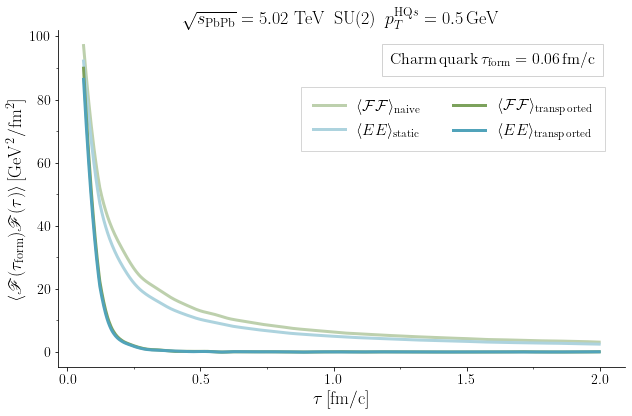

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.signal import savgol_filter
import numpy as np

plt.rcParams['text.latex.preamble'] = r'\usepackage{mathrsfs}'
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()

plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(2)}\,\,\,p_T^{\mathrm{HQ}s}=0.5\,\mathrm{GeV}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\langle \mathscr{F}(\tau_\mathrm{form})\mathscr{F}(\tau)\rangle\,\mathrm{[GeV^2/fm^2]}$', size = 18)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
if quark=='charm':
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    textstr = r'$\mathrm{Charm\,quark\,}\tau_\mathrm{form}=0.06\,\mathrm{fm/c}$'
    loc_text = 0.585
elif quark=='beauty':
    ax.yaxis.set_major_locator(MultipleLocator(50))
    ax.yaxis.set_minor_locator(MultipleLocator(25))
    textstr = r'$\mathrm{Beauty\,quark\,}\tau_\mathrm{form}=0.02\,\mathrm{fm/c}$'
    loc_text = 0.535

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

tags = ['naive', 'transported']
labels_e, labels_f = [r'$\langle EE\rangle_\mathrm{static}$', r'$\langle EE\rangle_\mathrm{transported}$'], [r'$\langle \mathcal{F}\mathcal{F}\rangle_\mathrm{naive}$', r'$\langle \mathcal{F}\mathcal{F}\rangle_\mathrm{transported}$']
colors_e, colors_f = ['#ADD3DE', '#51A3BA'], ['#BDD0AD', '#7CA25C']

value = 0.1
absolute_val_array = np.abs(tau - value)
index = absolute_val_array.argmin()

data = pickle.load(open(wong_path + 'avg.pickle', 'rb'))
mean_EformE, std_EformE, mean_FformF, std_FformF, tau = data['mean_EformE'], data['std_EformE'], data['mean_FformF'], data['std_FformF'], data['tau']

i=0
tau_decays = []
info = []
for tag in tags:
    ax.plot(tau[1:len(tau)], savgol_filter(mean_FformF[tag], 51, 2), linestyle = 'solid', color = colors_f[i], markersize = 0, linewidth = 3, label = labels_f[i])
    ax.plot(tau[1:len(tau)], savgol_filter(mean_EformE[tag], 51, 2), linestyle = 'solid', color = colors_e[i], markersize = 0, linewidth = 3, label = labels_e[i])
    # ax.plot(tau[1:len(tau)], mean_FformF[tag], linestyle = 'solid', color = colors_f[i], markersize = 0, linewidth = 3, label = labels_f[i])
    # ax.plot(tau[1:len(tau)], mean_EformE[tag], linestyle = 'solid', color = colors_e[i], markersize = 0, linewidth = 3, label = labels_e[i])
    i=i+1

leg = ax.legend(fontsize = 16, loc = 'upper right', ncol=2, bbox_to_anchor=(0.97,0.84))
leg.get_frame().set_boxstyle('square')

props = dict(boxstyle='square', facecolor='white', alpha=0.7, edgecolor='silver', pad=0.5)
ax.text(loc_text, 0.935, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)

plt.tight_layout()